In [1]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)

if length%2==0:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:-1]/2,
                                                [noise_psd[-1]],
                                                noise_psd[-2:0:-1]/2))
else:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:]/2,
                                                noise_psd[-1:0:-1]/2))
    
template_fft = fft(template)/sampling_frequency

kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft))*sampling_frequency/3276800
filter_kernel = kernel_fft / kernel_normalization
kernel_td = np.real(ifft(filter_kernel)) * sampling_frequency


In [2]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='NR',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

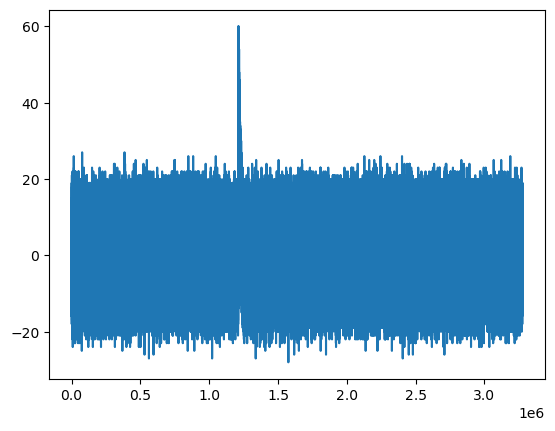

In [3]:
example = trace[7]
plt.plot(example)

Global optimum filter completed in 0.0025 seconds.


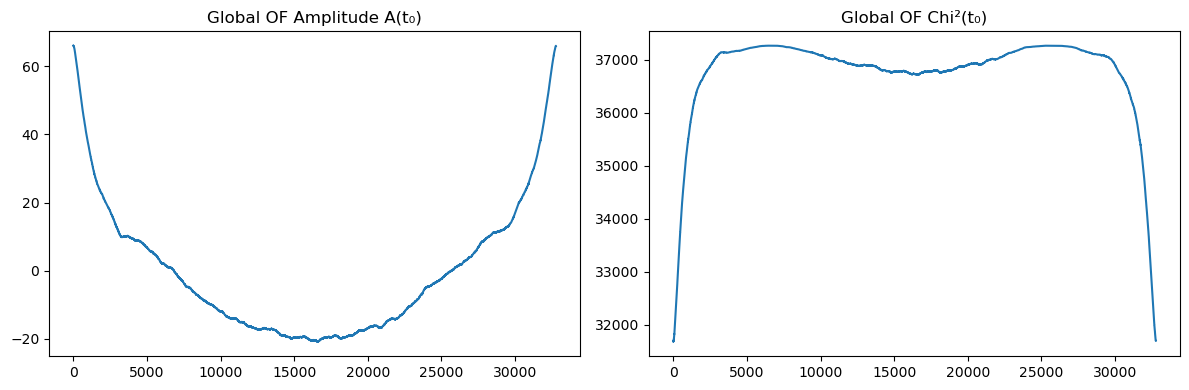

In [11]:
import time

# Global Optimum Filter (frequency-domain)

L_example = len(example)
L_temp = len(template)

# 1. Pad template to match trace
template_padded = np.pad(template, (0, L_example - L_temp))

# 2. FFT of template and trace
template_fft = fft(template_padded) / sampling_frequency
example_fft = fft(example) / sampling_frequency

# 3. Unfold noise PSD to full length
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))

# Avoid divide-by-zero or inf
noise_psd_unfolded = np.where(noise_psd_unfolded == 0, 1e30, noise_psd_unfolded)

# 4. Build filter kernel
kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / L_example
filter_kernel_fft = kernel_fft / kernel_normalization
start_time = time.perf_counter()

# 5. Apply to full trace
filtered_fft = example_fft * filter_kernel_fft
amp_t0_global = np.real(ifft(filtered_fft)) * sampling_frequency

# 6. Estimate chi^2(t0)
power_fft = example_fft.conj() * example_fft / noise_psd_unfolded
chi0_global = np.real(np.sum(power_fft)) * sampling_frequency / L_example
chi2_t0_global = chi0_global - amp_t0_global**2 * kernel_normalization
elapsed_time = time.perf_counter() - start_time
print(f"Global optimum filter completed in {elapsed_time:.4f} seconds.")

# Optional visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global)
plt.title("Global OF Amplitude A(t₀)")
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global)
plt.title("Global OF Chi²(t₀)")
plt.tight_layout()
plt.show()

Global optimum filter completed in 0.2855 seconds.


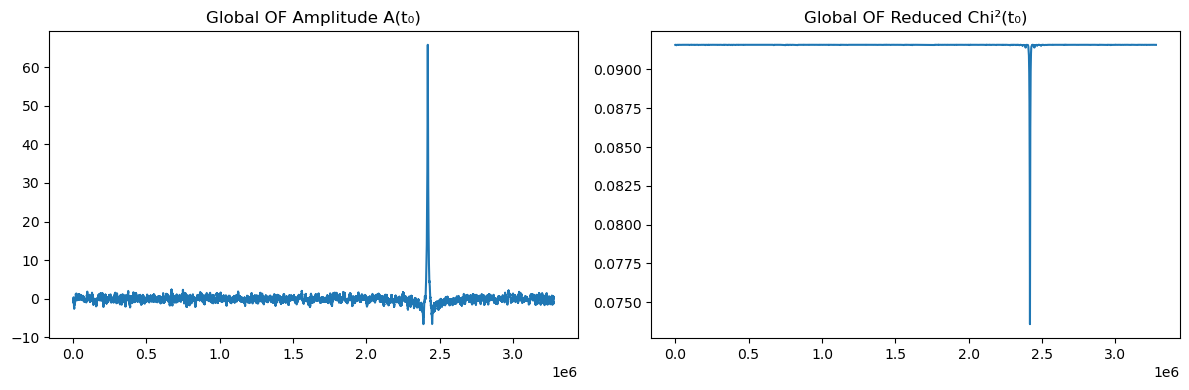

In [14]:
import time

# Global Optimum Filter (frequency-domain)

L_example = len(example)
L_temp = len(template)

# 1. Pad template to match trace
template_padded = np.pad(template, (0, L_example - L_temp))

# 2. FFT of template and trace
template_fft = fft(template_padded) / sampling_frequency
example_fft = fft(example) / sampling_frequency

# 3. Unfold noise PSD to full length
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))
noise_psd_unfolded = np.where(noise_psd_unfolded == 0, 1e30, noise_psd_unfolded)

# 4. Build filter kernel
kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / L_example
filter_kernel_fft = kernel_fft / kernel_normalization

# Start timing after setup
start_time = time.perf_counter()

# 5. Apply to full trace
filtered_fft = example_fft * filter_kernel_fft
amp_t0_global = np.real(ifft(filtered_fft)) * sampling_frequency

# 6. Estimate chi^2(t0)
power_fft = example_fft.conj() * example_fft / noise_psd_unfolded
chi0_global = np.real(np.sum(power_fft)) * sampling_frequency / L_example
chit_withdelay = amp_t0_global**2 * kernel_normalization
chi2_t0_global = (chi0_global - chit_withdelay) / (L_example - 3)  # normalize by DOF

elapsed_time = time.perf_counter() - start_time
print(f"Global optimum filter completed in {elapsed_time:.4f} seconds.")

# Optional visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global)
plt.title("Global OF Amplitude A(t₀)")
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global)
plt.title("Global OF Reduced Chi²(t₀)")
plt.tight_layout()
plt.show()


In [16]:
index = np.argmax(amp_t0_global)
print(index)

2417791


In [17]:
idx

2417779